In [50]:
import numpy as np
import pandas as pd
import seaborn as sns

In [51]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

--2024-10-11 00:30:48--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv.1’

laptops.csv.1       100%[===================>] 291,58K  --.-KB/s    in 0,04s   

2024-10-11 00:30:48 (6,57 MB/s) - ‘laptops.csv.1’ saved [298573/298573]



In [52]:
df = pd.read_csv("laptops.csv")
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [53]:
columns = ['ram', 'storage', 'screen', 'final_price']
df_use = df[columns]

/home/unjoku/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


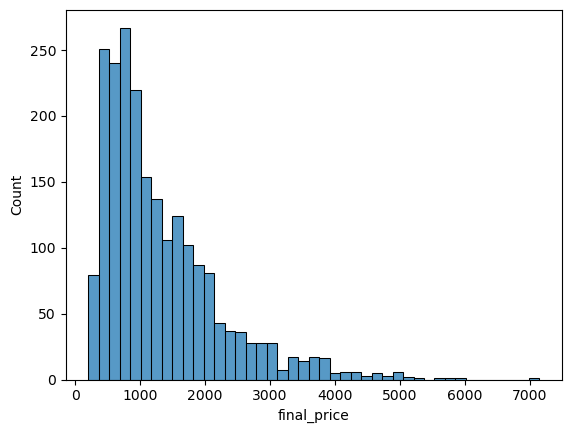

In [54]:
sns.histplot(df_use["final_price"]);

## Question 1
- There's one column with missing values. What is it?

In [55]:
df_use.isna().sum()[df_use.isna().sum() > 0]

screen    4
dtype: int64

## Question 2
- What's the median (50% percentile) for variable 'ram'?

In [56]:
df_use.ram.describe()

count    2160.000000
mean       15.413889
std         9.867815
min         4.000000
25%         8.000000
50%        16.000000
75%        16.000000
max       128.000000
Name: ram, dtype: float64

## Prepare and split the dataset

- Shuffle the dataset (the filtered one you created above), use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.

In [57]:
n = len(df_use)
nval = int(0.2 * n)
ntest = int(0.2 * n)
ntrain = n - (nval + ntest)
assert (nval+ ntest +ntrain) == n

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
df_shuffled = df_use.iloc[idx]

df_train = df_shuffled.iloc[:ntrain]
df_val = df_shuffled.iloc[ntrain:ntrain+nval]
df_test = df_shuffled.iloc[ntrain+nval:]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['final_price'].values
y_val = df_val['final_price'].values
y_test = df_test['final_price'].values

In [58]:
df_shuffled

,ram,storage,screen,final_price
2079,32,1000,15.6,1123.29
668,4,64,14.1,201.05
2073,32,1000,14.0,997.74
1113,16,512,13.3,1016.00
788,32,1000,16.0,2739.00
...,...,...,...,...
1638,8,512,15.0,1838.29
1095,8,256,15.6,531.80
1130,8,256,13.3,765.33
1294,8,512,14.0,803.61


## Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

In [59]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]


In [60]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

### Option 1

In [61]:
# Training
df_val1 = df_val.copy()
df_test1 = df_test.copy()
df_train1 = df_train.copy()

df_val1.screen.fillna(0, inplace=True)
df_test1.screen.fillna(0, inplace=True)
df_train1.screen.fillna(0, inplace=True)

w01, w1 = train_linear_regression(df_train1.values, y_train)
y_pred1 = w01 + df_train1.values.dot(w1)

/home/unjoku/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/unjoku/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


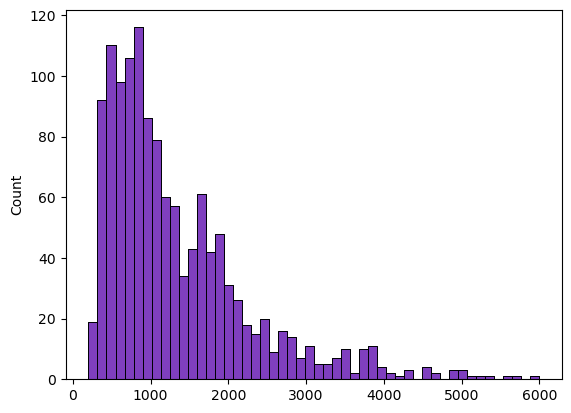

In [62]:
sns.histplot(y_pred1, color="red", alpha=0.5, bins = 50)
sns.histplot(y_train, color="blue", alpha=0.5, bins = 50);

In [63]:
# Evaluation
y_pred1 = w01 + df_val1.values.dot(w1)
round(rmse(y_val, y_pred1), 2)

0.0

### Option 2

In [64]:
fill_mean = df_train.screen.mean()

df_val2 = df_val.copy()
df_test2 = df_test.copy()
df_train2 = df_train.copy()

df_val2.screen.fillna(fill_mean, inplace=True)
df_test2.screen.fillna(fill_mean, inplace=True)
df_train2.screen.fillna(fill_mean, inplace=True)

w02, w2 = train_linear_regression(df_train2.values, y_train)
y_pred2 = w02 + df_train2.values.dot(w2)

/home/unjoku/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/unjoku/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


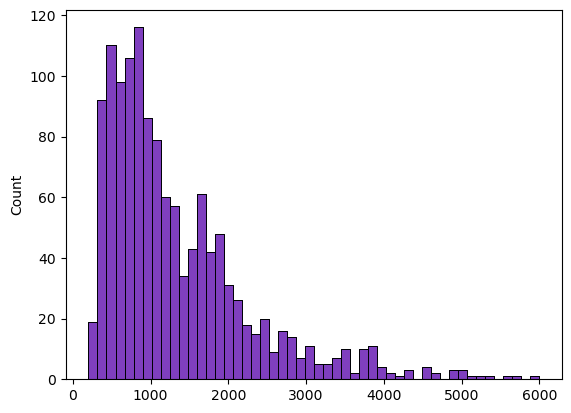

In [65]:
sns.histplot(y_pred2, color="red", alpha=0.5, bins = 50)
sns.histplot(y_train, color="blue", alpha=0.5, bins = 50);

In [66]:
# Evaluation
y_pred2 = w01 + df_val2.values.dot(w1)
round(rmse(y_val, y_pred2), 2)

0.0

## Question 4
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

In [67]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [68]:
rs = [0, 0.01, 0.1, 1, 5, 10, 100]
for r in rs:
    w01, w1  = train_linear_regression_reg(df_train1.values, y_train, r=r)
    y_pred1 = w01 + df_val1.values.dot(w1)
    print(r, round(rmse(y_val, y_pred1), 2))

0 0.0
0.01 0.0
0.1 0.0
1 0.0
5 0.0
10 0.0
100 0.0


## Question 5
- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

In [69]:
rmses = []
for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:  
    np.random.seed(s)
    n = len(df_use)
    nval = int(0.2 * n)
    ntest = int(0.2 * n)
    ntrain = n - (nval + ntest)
    assert (nval+ ntest +ntrain) == n

    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled = df_use.iloc[idx]

    df_train = df_shuffled.iloc[:ntrain]
    df_val = df_shuffled.iloc[ntrain:ntrain+nval]
    df_test = df_shuffled.iloc[ntrain+nval:]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train['final_price'].values
    y_val = df_val['final_price'].values
    y_test = df_test['final_price'].values

    del df_val['final_price']
    del df_test['final_price']
    del df_train['final_price']

    # Training
    df_val1 = df_val.copy()
    df_test1 = df_test.copy()
    df_train1 = df_train.copy()

    df_val1.screen.fillna(0, inplace=True)
    df_test1.screen.fillna(0, inplace=True)
    df_train1.screen.fillna(0, inplace=True)

    w01, w1 = train_linear_regression(df_train1.values, y_train)
    y_pred1 = w01 + df_val1.values.dot(w1)
    rmses.append(round(rmse(y_val, y_pred1),2))


print(round(np.std(rmses), 3))

29.176


## Question 6

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

In [70]:
np.random.seed(9)
n = len(df_use)
nval = int(0.2 * n)
ntest = int(0.2 * n)
ntrain = n - (nval + ntest)
assert (nval+ ntest +ntrain) == n

idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df_use.iloc[idx]

df_train = df_shuffled.iloc[:ntrain]
df_val = df_shuffled.iloc[ntrain:ntrain+nval]
df_test = df_shuffled.iloc[ntrain+nval:]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['final_price'].values
y_val = df_val['final_price'].values
y_test = df_test['final_price'].values

del df_val['final_price']
del df_test['final_price']
del df_train['final_price']

# Training
df_val1 = df_val.copy()
df_test1 = df_test.copy()
df_train1 = df_train.copy()

df_val1.screen.fillna(0, inplace=True)
df_test1.screen.fillna(0, inplace=True)
df_train1.screen.fillna(0, inplace=True)

newx = np.concatenate((df_train1, df_val1) , axis=0)
newy = np.concatenate((y_train , y_val), axis=0)

w01, w1  = train_linear_regression_reg(newx, newy, r=0.001)
y_pred1 = w01 + df_test1.values.dot(w1)
print(round(rmse(y_test, y_pred1),2))

608.61
